<a href="https://colab.research.google.com/github/DanielTaylor97/HonoursProject/blob/master/FCN_MNISTheatmaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS

In [0]:
from __future__ import division, absolute_import, print_function, unicode_literals
import tensorflow as tf
import tensorflow.contrib.graph_editor as ge
from tensorflow.keras import datasets, layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import PIL, PIL.Image
import os
from scipy import signal

DOWNLOADING AND PREPARING THE MNIST DATASET

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

#train_images = train_images.reshape(60000, 28, 28, 1)
#test_images = test_images.reshape(10000, 28, 28, 1)
##reshaping to 60000 and 10000 28*28*1 tensors (1 because b&w)

#print(test_images.shape)

train_images = train_images/225
test_images = test_images/225
#normalising pixel values

FULLY-CONNECTED BASE STRUCTURE

In [3]:
model = models.Sequential()
model.add(layers.Flatten(input_shape = (28, 28)))
model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

W0823 14:58:09.795007 140400600430464 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


COMPILE THE MODEL

In [0]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

CONFIGURE CHECKPOINTS

In [0]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

TRAINING THE MODEL

In [6]:
model.fit(train_images, train_labels, epochs = 5, callbacks = [cp_callback])

Epoch 1/5
59552/60000 [============================>.] - ETA: 0s - loss: 0.2061 - acc: 0.9372
Epoch 00001: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 5s 91us/sample - loss: 0.2057 - acc: 0.9373
Epoch 2/5
59488/60000 [============================>.] - ETA: 0s - loss: 0.0852 - acc: 0.9737
Epoch 00002: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0851 - acc: 0.9737
Epoch 3/5
59584/60000 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9810
Epoch 00003: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 5s 92us/sample - loss: 0.0604 - acc: 0.9810
Epoch 4/5
59808/60000 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9859
Epoch 00004: saving model to training_1/cp.ckpt
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0430 - acc: 0.9859
Epoch 5/5
59872/60000 [============================>.] - ETA: 0s - l

FIND ACCURACY OF MODEL

SAVE MODEL

In [0]:
model.save('MNISTmodelFC.h5')

HEATMAPS UTILS

In [0]:
#import numpy,PIL,PIL.Image

lowest = -1.0
highest = 1.0

# --------------------------------------
# Sampling data
# --------------------------------------

def getMNISTsample(N=12,seed=None,path=''):

  fx = '%s/t10k-images-idx3-ubyte'%path
  ft = '%s/t10k-labels-idx1-ubyte'%path

  X  = np.fromfile(open(fx),dtype='ubyte',count=16+784*10000)[16:].reshape([10000,784])
  T  = np.fromfile(open(ft),dtype='ubyte',count=8+10000)[8:]
  T  = (T[:,np.newaxis]  == np.arange(10))*1.0

  if seed==None: seed=np.random
  else: seed=np.random.mtrand.RandomState(seed)

  R = seed.randint(0,len(X),[N])
  X,T = X[R],T[R]

  return X/255.0*(highest-lowest)+lowest,T

# --------------------------------------
# Color maps ([-1,1] -> [0,1]^3)
# --------------------------------------

def heatmap(x):

  x = x[...,np.newaxis]

  # positive relevance
  hrp = 0.9 - np.clip(x-0.3,0,0.7)/0.7*0.5
  hgp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4
  hbp = 0.9 - np.clip(x-0.0,0,0.3)/0.3*0.5 - np.clip(x-0.3,0,0.7)/0.7*0.4

  # negative relevance
  hrn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
  hgn = 0.9 - np.clip(-x-0.0,0,0.3)/0.3*0.5 - np.clip(-x-0.3,0,0.7)/0.7*0.4
  hbn = 0.9 - np.clip(-x-0.3,0,0.7)/0.7*0.5

  r = hrp*(x>=0)+hrn*(x<0)
  g = hgp*(x>=0)+hgn*(x<0)
  b = hbp*(x>=0)+hbn*(x<0)

  return np.concatenate([r,g,b],axis=-1)


def graymap(x):

  x = x[...,np.newaxis]
  return np.concatenate([x,x,x],axis=-1)*0.5+0.5

# --------------------------------------
# Visualizing data
# --------------------------------------

def visualize(x,colormap,name):

  N = len(x); assert(N<=16)

  x = colormap(x/np.abs(x).max())

  # Create a mosaic and upsample
  x = x.reshape([1,N,28,28,3])
  x = np.pad(x,((0,0),(0,0),(2,2),(2,2),(0,0)),'constant',constant_values=1)
  x = x.transpose([0,2,1,3,4]).reshape([1*32,N*32,3])
  x = np.kron(x,np.ones([2,2,1]))

  PIL.Image.fromarray((x*255).astype('byte'),'RGB').save(name)

HEATMAPS MODULES

In [0]:
#import numpy

# -------------------------
# Feed-forward network
# -------------------------
class Network:
  
  def __init__(self,layers):
    self.layers = layers
    
  def forward(self,Z):
    for l in self.layers: Z = l.forward(Z) #passes parameter Z forward throguh network -- Z recieved initially as the pixel array
    return Z
  
  def gradprop(self,DZ):
    for l in self.layers[::-1]: DZ = l.gradprop(DZ)
    return DZ
  
  #THIS IS ADDED BY ME
  def relprop(self, R):
    for l in self.layers[::-1]:
      R = l.relprop(R)
    return R

# -------------------------
# ReLU activation layer
# -------------------------
class ReLU:
  
  def forward(self,X):
    self.Z = X>0
    return X*self.Z
  
  def gradprop(self,DY):
    return DY*self.Z
  
  #THIS IS ADDED BY ME
  def relprop(self, R):
    return R

# -------------------------
# Fully-connected layer
# -------------------------

class FirstLinear:
  
  #def __init__(self, W, B):
  #  self.W = W
  #  self.B = B
  
  def __init__(self,name):
    self.W = np.loadtxt(name+'-W.txt') #Fetches weights vector for a given layer
    self.B = np.loadtxt(name+'-B.txt') #Fetches biases vector for a given layer
    
  def forward(self,X):
    self.X = X
    return np.dot(self.X,self.W)+self.B
  
  def gradprop(self,DY):
    self.DY = DY
    return np.dot(self.DY,self.W.T)
  
  #THIS IS ADDED BY ME
  #Z^B RULE
  def relprop(self, R):
    W = self.W
    V = np.maximum(0, W)
    U = np.minimum(0, W)
    X = self.X
    L = self.X*0 + lowest  #vector of the same number -- lower bound
    H = self.X*0 + highest #vector of the same number -- upper bound
    
    Z = np.dot(X, W) - np.dot(L, V) - np.dot(H, U) + 1e-9
    S = R/Z
    R = X*np.dot(S, W.T) - L*np.dot(S, V.T) - H*np.dot(S, U.T)
    return R

########

class NextLinear:
  
  #def __init__(self, W, B):
  #  self.W = W
  #  self.B = B
  
  def __init__(self,name):
    self.W = np.loadtxt(name+'-W.txt') #Fetches weights vector for a given layer
    self.B = np.loadtxt(name+'-B.txt') #Fetches biases vector for a given layer

  def forward(self,X):
    self.X = X
    return np.dot(self.X,self.W)+self.B

  def gradprop(self,DY):
    self.DY = DY
    return np.dot(self.DY,self.W.T)
  
  #THIS IS ADDED BY ME
  #Z^+ RULE
  def relprop(self, R):
    V = np.maximum(0, self.W)
    Z = np.dot(self.X, V) + 1e-9 #we divide by this later -- no division by zero!
    S = R/Z
    C = np.dot(S, V.T)
    R = self.X*C
    return R
  #This propagation method does not apply to the input layers, but to the layers following it

# -------------------------
# Sum-pooling layer
# -------------------------
class Pooling:

  def forward(self,X):
    self.X = X
    self.Y = 0.5*(X[:,::2,::2,:]+X[:,::2,1::2,:]+X[:,1::2,::2,:]+X[:,1::2,::2,:])
    return self.Y

  def gradprop(self,DY):
    self.DY = DY
    DX = self.X*0
    for i,j in [(0,0),(0,1),(1,0),(1,1)]: DX[:,i::2,j::2,:] += DY*0.5
    return DX

# -------------------------
# Convolution layer
# -------------------------
class Convolution:

  def __init__(self,name):
    wshape = map(int,list(name.split("-")[-1].split("x")))
    self.W = np.loadtxt(name+'-W.txt').reshape(wshape)
    self.B = np.loadtxt(name+'-B.txt')

  def forward(self,X):

    self.X = X
    mb,wx,hx,nx = X.shape
    ww,hw,nx,ny = self.W.shape
    wy,hy       = wx-ww+1,hx-hw+1

    Y = np.zeros([mb,wy,hy,ny],dtype='float32')

    for i in range(ww):
      for j in range(hw):
        Y += np.dot(X[:,i:i+wy,j:j+hy,:],self.W[i,j,:,:])

    return Y+self.B

  def gradprop(self,DY):

    self.DY = DY
    mb,wy,hy,ny = DY.shape
    ww,hw,nx,ny = self.W.shape

    DX = self.X*0

    for i in range(ww):
      for j in range(hw):
        DX[:,i:i+wy,j:j+hy,:] += np.dot(DY,self.W[i,j,:,:].T)

    return DX

In [0]:
def forward_first(X, W, B):
  return np.matmul(X, W) + B

def relprop_first(X, W, R):
  V = np.maximum(0, W)
  U = np.minimum(0, W)
  L = X*0 + lowest  #vector of the same number -- lower bound
  H = X*0 + highest #vector of the same number -- upper bound
  
  Z = np.matmul(X, W) - np.matmul(L, V) - np.matmul(H, U) + 1e-9
  S = R/Z
  R = X*np.dot(S, W.T) - L*np.dot(S, V.T) - H*np.dot(S, U.T)
  return R
  
def forward_next(X, W, B):
  return np.matmul(X, W) + B

def relprop_next(X, W, R):
  V = np.maximum(0, W)
  Z = np.matmul(X, V) + 1e-9 #we divide by this later -- no division by zero!
  S = R/Z
  C = np.dot(S, V.T)
  R = X*C
  return R
  
def forward_relu(X):
  Z = X>0
  return X*Z

def relprop_relu(R):
  return R
  


IMPLEMENTING HEATMAPPINGS

In [10]:
map_model = models.Sequential()
map_model.add(layers.Flatten(input_shape = (28, 28)))
map_model.add(layers.Dense(300, activation = 'relu'))
map_model.add(layers.Dense(100, activation = 'relu'))
map_model.add(layers.Dense(10))

map_model.load_weights(checkpoint_path)
#can also use model.get_weights(), map_model.setweights(...)

In [0]:
map_model.save('MNISTmodelFC_map.h5')

In [11]:
positions = np.random.randint(0, 10000, size = (12,))
X, L = test_images[:12, :, :], test_labels[:12]

n = 0

images_to_map = np.empty(shape = (1, 28, 28))

for i in range(0, 12):
  X[i, :, :] = test_images[positions[i], :, :]
  L[i] = test_labels[positions[i]]
  #plt.imshow(X[i], cmap = 'gray')
  #plt.axis('off')
  one_prediction = map_model.predict(X[i:(i + 1), :, :])
  decision = np.argmax(one_prediction)
  if decision == L[i]:
    print(decision)
    print(one_prediction)
    #plt.show()
    n += 1
    images_to_map = np.append(images_to_map, X[i:(i + 1), :, :], axis = 0)
  else:
    print('!!! decision {} not equal to value {} !!!'.format(decision, L[i]))

images_to_map = np.delete(images_to_map, 0, 0)
print('Shape of images array: {}'.format(images_to_map.shape))

print('Total number of acceptable examples: {}'.format(n))

4
[[-13.850538   -7.473386   -4.966731  -11.052797   19.021755   -6.293179
   -7.5808487   0.9184332  -9.281849    0.8467531]]
7
[[ -6.132525    1.4654627   5.030587    4.0176206  -6.4107914  -4.5496526
  -10.339362   13.61875    -4.002308    0.3409448]]
8
[[-1.5928313  -4.0510006  -2.395238   -0.23917943 -4.9456325  -2.1548235
  -4.4699025  -2.6065392   9.754496    0.19668823]]
2
[[-1.742328   -1.0062978  10.039279    4.636064   -4.422592   -3.2301307
  -5.7476525   0.48309472 -0.5067519  -4.3130555 ]]
3
[[-10.088497   -4.7282696  -3.0256808  14.116441   -8.918514    4.5859284
  -14.382353   -6.9061966   0.7100564   5.613453 ]]
0
[[11.23454    -8.909072    2.238021   -5.687389   -5.343596   -3.4588335
   0.172503   -1.9187597  -4.955027    0.40798232]]
1
[[-8.398996  15.051525  -1.2526895 -3.7965415  1.3196008 -4.632089
  -2.8608377  2.7780392  1.1390665 -3.175701 ]]
2
[[ -6.3098316   3.467865   21.539724    2.5974228  -2.7984054  -8.211766
   -5.8723845   4.557456   -0.8770653 -10.12

In [0]:
W1 = np.asarray(map_model.get_weights()[0]) #784 lists of 300 weights --> array
B1 = np.asarray(map_model.get_weights()[1]) #list of 300 biases --> array
W2 = np.asarray(map_model.get_weights()[2]) #300 lists of 100 weights --> array
B2 = np.asarray(map_model.get_weights()[3]) #list of 100 biases --> array
W3 = np.asarray(map_model.get_weights()[4]) #100 lists of 10 weights --> array
B3 = np.asarray(map_model.get_weights()[5]) #list of 10 biases --> array

4


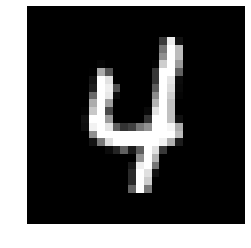

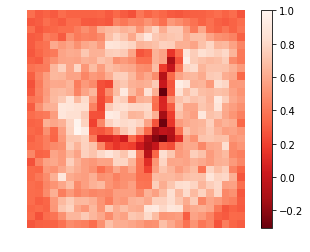

7


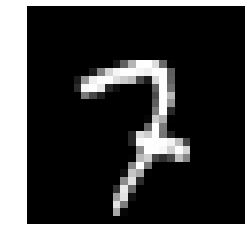

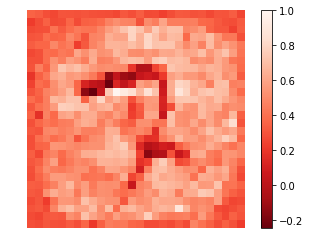

8


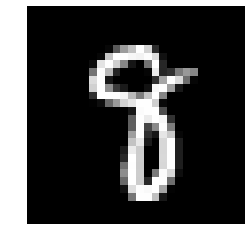

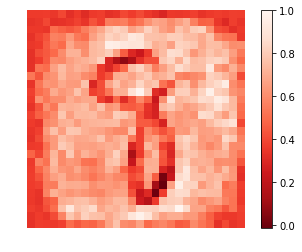

2


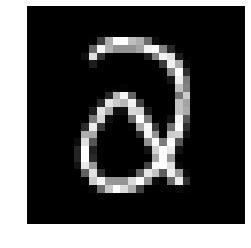

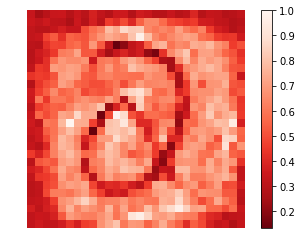

3


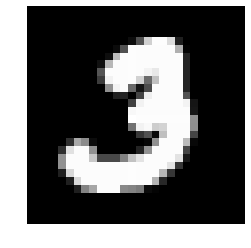

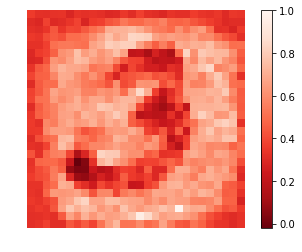

0


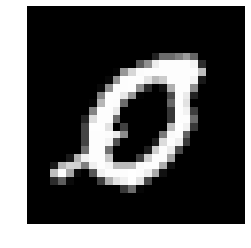

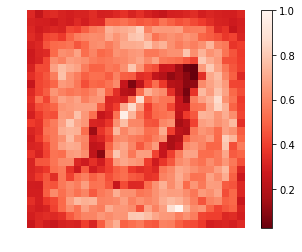

1


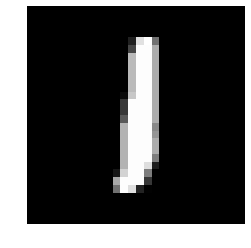

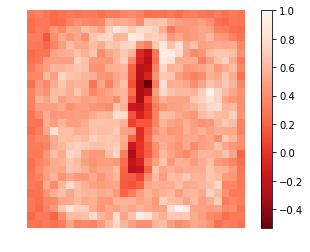

2


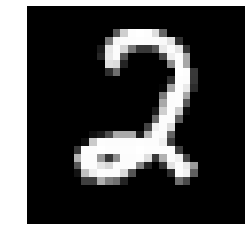

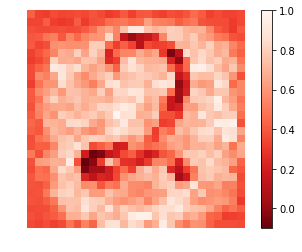

5


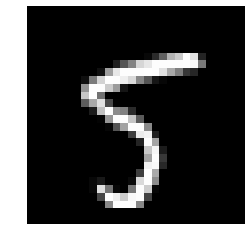

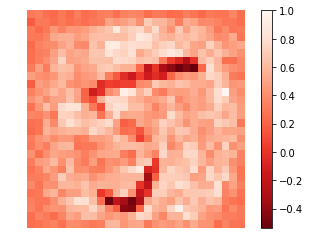

3


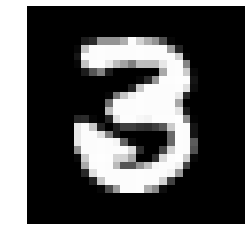

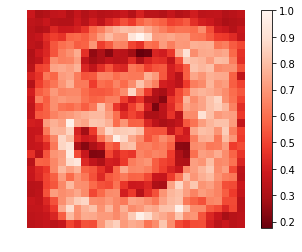

1


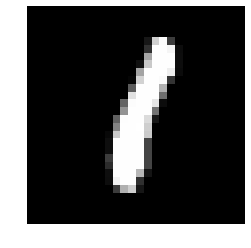

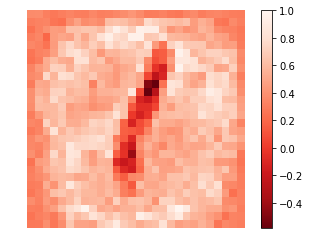

2


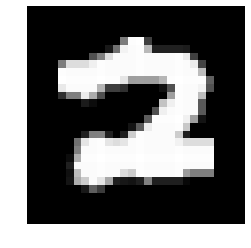

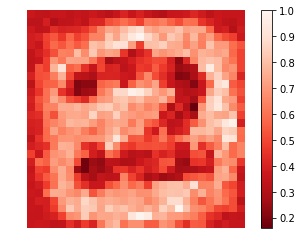

In [16]:
X0 = np.zeros(784)
X1 = np.zeros(300)
Relu1 = np.zeros(300)
X2 = np.zeros(100)
Relu2 = np.zeros(100)
X3 = np.zeros(10)

R = np.zeros(10)

LK = np.zeros((n, 10))
#print(L)
for j in range(0, n):
  LK[j, :] = signal.unit_impulse(10, L[j])
#print(LK)

for k in range(0, n):
  X0 = images_to_map[k, :, :]
  X0.shape = (784)
  X1 = forward_first(X0, W1, B1)
  Relu1 = forward_relu(X1)
  X2 = forward_next(Relu1, W2, B2)
  Relu2 = forward_relu(X2)
  X3 = forward_next(Relu2, W3, B3)
  #print(X3)
  
  R = X3*0 #Output layer relevances
  R[int(np.argmax(X3))] = np.dot(X3, LK[k, :])
  #R = X3
  #R = relprop_relu(R)
  R = relprop_next(X2, W3, R)
  #R = relprop_relu(R)
  R = relprop_next(X1, W2, R)
  R = relprop_first(X0, W1, R)
  
  R.shape = (28*28)
  r = np.max(R)
  
  R.shape = (28, 28)
  print(L[k])
  plt.imshow(images_to_map[k, :, :], cmap = 'gray')
  plt.axis('off')
  plt.savefig('gmap{}'.format(k))
  plt.show()
  plt.imshow(R/r, cmap = 'Reds_r')
  plt.colorbar()
  plt.axis('off')
  plt.savefig('hmap{}'.format(k))
  plt.show()
  

In [0]:
map_model.save('MNISTmapmodelFC.h5')

In [18]:
map_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [17]:
from google.colab import files

print(n)

for m in range(0, n):
  #files.download('gmap{}.png'.format(m))
  #files.download('hmap{}.png'.format(m))

12
